- At first we are going to assume there's no meaning to the order in which samples appear in the table: such a table is a collection of independent samples, unlike a time series, for instance, in which samples are related by a **time dimension**.
- **Tabular data is typically not homogeneous**: **different columns don't have the same type**.
- **PyTorch tensors**, on the other hand, **are homogeneous**.

### 4.3.1 Using a real-world dataset
- Our first job as deep learning practitioners is to encode **heterogeneous, real-world data** into a tensor of floating-point numbers, ready for consumption by a neural network.
- freely available tabular datasets, 例えば：https://github.com/awesomedata/awesome-public-datasets
- The Wine Quality dataset contains chemical characterizations of samples of *vinho verde*, a wine from north Portugal, together with a sensory quality score.

In [1]:
from PIL import Image
import torch

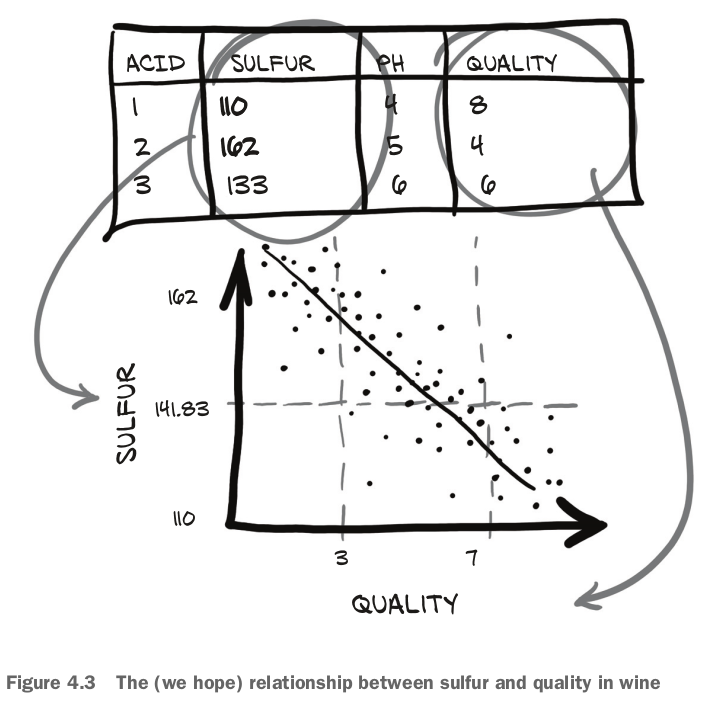

In [2]:
Image.open('img/possible-machine-learning-task-2020-12-14-13-23-01.png')

### 4.3.2 Loading a wine data tensor
- Python offers several options for quickly loading a CSV file. 3 popular options are:
    - The `csv` module that ships with Python
    - NumPy
    - Pandas (**the most time- and memory-efficient**)

In [4]:
import csv
import numpy as np

In [5]:
wine_path = '../data/p1ch4/tabular-wine/winequality-white.csv'
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=';',
                        skiprows=1)
wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

- `skiprows=1`: the first line should not be read since it contains the column names.

In [6]:
col_list = next(csv.reader(open(wine_path), delimiter=';'))
wineq_numpy.shape, col_list

((4898, 12),
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'])

In [7]:
wineq = torch.from_numpy(wineq_numpy)
wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

### Continuous, ordinal(序数), and categorical values
- 参考：https://en.wikipedia.org/wiki/Level_of_measurement
- We should be aware of 3 different kinds of numerical values as we attempt to **make sense of out data**.
- continuous value(**strictly ordered, a difference between various values has a strict meaning**)の2種類
    - ratio scale: AがBの何倍かを言える。
    - interval scale: 例えばtime of day, does have the notion of difference, but it is not reasonable to claim that 6:00 is twice as late as 3:00.
- ordinal value: the strict ordering we have with continuous values remains, but **the fixed relationship between values no longer applies**.
    - Remember we **can't "do math" on the values** outside of ordering them.
- categorical value: neither ordering nor numerical meaning.
    - because the numerical values bear no meaning, they are said to be on a **nominal scale**.

### 4.3.3 Representing scores
- We could **treat the score as a continuous variable**, keep it as a real number, and perform a regression task, or **treat it as a label** and try to guess the label from the chemical analysis in a classification task.
- Typically **remove the score from the tensor of input data and keep it in a separate tensor**:

In [8]:
data = wineq[:, :-1]
data, data.shape

(tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
         [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
         ...,
         [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]),
 torch.Size([4898, 11]))

In [9]:
target = wineq[:, -1]
target, target.shape

(tensor([6., 6., 6.,  ..., 6., 7., 6.]), torch.Size([4898]))

- If we want to transform the `target` tensor in a tensor of labels.
    - One is simply to treat labels as an integer vector of scores:

In [10]:
target = wineq[:, -1].long()
target

tensor([6, 6, 6,  ..., 6, 7, 6])

### 4.3.4 One-hot encoding
- The other approach is to build a one-hot encoding of the scores.
- There's a marked difference between the two approaches.
    - Keeping wine quality scores in a integer vector of scores induces an ordering on the scores - which might be totally appropriate in this case.
    - It also induces some sort of distance between scores.
    - If, on the other hand, **scores are purely discrete, like grape variety**, one-hot encoding will be a much better fit.
    - One-hot encoding is also appropriate for quantitative scores when **fractional values** in between integer scores **make no sense** for the application.
- We can **achieve one-hot encoding using the `scatter_` method**, which **fills the tensor** with values from a **source tensor** along the indices provided as arguments:

In [11]:
target_onehot = torch.zeros(target.shape[0], 10)

target_onehot.scatter_(1, target.unsqueeze(1), 1.0)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

- `scatter_`の引数の意味：
    - The **dimension along which** the following two arguments are specified.
    - A **column tensor** indicating the indices of the elements to scatter.
    - A tensor containing the elements to scatter or a single scalar to scatter.
- なので、上記2行目の意味は：**For each row** (1の意味), take the **index** of the target label and use it as the **column index** to set the value 1.0.
- The 2nd argument of `scatter_`, the index tensor, is required to have the same **number of dimensions** as the tensor we scatter into.
    - Since `target_onehot` has two dimensions, we need to add an extra **dummy dimension** to `target` using `unsqueeze`:

In [12]:
target_unsqueezed = target.unsqueeze(1)
target_unsqueezed

tensor([[6],
        [6],
        [6],
        ...,
        [6],
        [7],
        [6]])

### 4.3.5 When to categorize

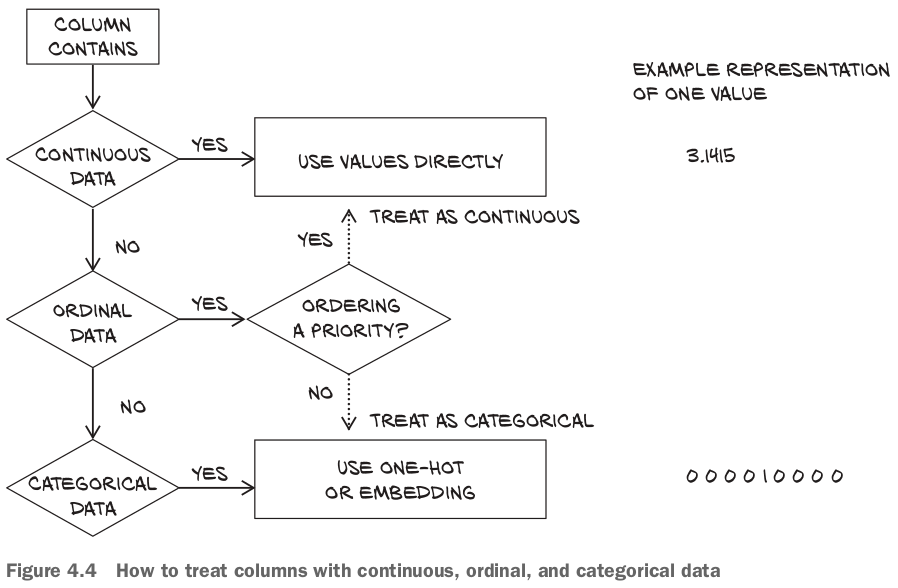

In [13]:
Image.open('img/when-to-categorize-2020-12-14-19-07-06.png')

- First obtain the mean and standard deviations for each column:

In [14]:
data_mean = torch.mean(data, dim=0)
data_mean

tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01])

In [15]:
data_var = torch.var(data, dim=0)
data_var

tensor([7.1211e-01, 1.0160e-02, 1.4646e-02, 2.5726e+01, 4.7733e-04, 2.8924e+02,
        1.8061e+03, 8.9455e-06, 2.2801e-02, 1.3025e-02, 1.5144e+00])

- At this point, we can normalize the data by subtracting the mean and dividing by the standard deviation:

In [16]:
data_normalized = (data - data_mean) / torch.sqrt(data_var)
data_normalized

tensor([[ 1.7208e-01, -8.1761e-02,  2.1326e-01,  ..., -1.2468e+00,
         -3.4915e-01, -1.3930e+00],
        [-6.5743e-01,  2.1587e-01,  4.7996e-02,  ...,  7.3995e-01,
          1.3422e-03, -8.2419e-01],
        [ 1.4756e+00,  1.7450e-02,  5.4378e-01,  ...,  4.7505e-01,
         -4.3677e-01, -3.3663e-01],
        ...,
        [-4.2043e-01, -3.7940e-01, -1.1915e+00,  ..., -1.3130e+00,
         -2.6153e-01, -9.0545e-01],
        [-1.6054e+00,  1.1666e-01, -2.8253e-01,  ...,  1.0049e+00,
         -9.6251e-01,  1.8574e+00],
        [-1.0129e+00, -6.7703e-01,  3.7852e-01,  ...,  4.7505e-01,
         -1.4882e+00,  1.0448e+00]])

### 4.3.6 Finding thresholds
- Determine which rows in `target` correspond to a score less than or equal to 3:

In [17]:
bad_indexes = target <= 3
bad_indexes.shape, bad_indexes.dtype, bad_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(20))

- By using a feature in PyTorch called **advanced indexing**, we can use a tensor **with data type `torch.bool`** to **index** the `data` tensor:

In [18]:
bad_data = data[bad_indexes]
bad_data.shape

torch.Size([20, 11])

- Now we can start to get information about wines grouped into good, middling, and bad categories. Let's take the `.mean()` of each column:

In [19]:
bad_data = data[target <= 3]
mid_data = data[(target > 3) & (target < 7)]
good_data = data[target >= 7]

bad_mean = torch.mean(bad_data, dim=0)
mid_mean = torch.mean(mid_data, dim=0)
good_mean = torch.mean(good_data, dim=0)

for i, args in enumerate(zip(col_list, bad_mean, mid_mean, good_mean)):
    print('{:2} {:20} {:6.2f} {:6.2f} {:6.2f}'.format(i, *args))

 0 fixed acidity          7.60   6.89   6.73
 1 volatile acidity       0.33   0.28   0.27
 2 citric acid            0.34   0.34   0.33
 3 residual sugar         6.39   6.71   5.26
 4 chlorides              0.05   0.05   0.04
 5 free sulfur dioxide   53.33  35.42  34.55
 6 total sulfur dioxide 170.60 141.83 125.25
 7 density                0.99   0.99   0.99
 8 pH                     3.19   3.18   3.22
 9 sulphates              0.47   0.49   0.50
10 alcohol               10.34  10.26  11.42


- 観察：the bad wines seem to have higher total sulfur dioxide(二酸化硫黄「にさんかいおう」), among other differences.
- Let's get the indexes where the total sulfur dioxide column is below the midpoint we calculated earlier:

In [20]:
total_sulfur_threshold = 141.83
total_sulfur_data = data[:, 6]
predicted_indexes = torch.lt(total_sulfur_data, total_sulfur_threshold)

predicted_indexes.shape, predicted_indexes.dtype, predicted_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(2727))

- Next, we'll need to get the indexes of the actually good wines:

In [21]:
actual_indexes = target > 5

actual_indexes.shape, actual_indexes.dtype, actual_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(3258))

- **Since there are about 500 more actually good wines than our threshold predicted, we already have hard evidence that it's not perfect**.
- Now we need to see how well **our predictions line up with the actual rankings**.
    - We will perform **a logical "and" between our prediction indexes and the actual good indexes** and use that **intersection** of wines-in-agreement to determine how well we did:

In [22]:
n_matches = torch.sum(actual_indexes & predicted_indexes).item()
n_predicted = torch.sum(predicted_indexes).item()
n_actual = torch.sum(actual_indexes).item()

n_matches, n_matches / n_predicted, n_matches / n_actual

(2018, 0.74000733406674, 0.6193984039287906)

- Unfortunately, there are 3,200 good wines, and we only identified 61% of them. (**Barely better than random!**)
- Of course, this is all very naive: we know for sure that multiple variables contribute to wine quality.
- Indeed, a simple neural network would overcome all of these limitations, as would a lot of other basic machine learning methods.